# MSPP Data Analysis Notebook

**Purpose**: Analyze mass spectrometry proteomics data from Orbitrap Astral MS (DIA-NN output)

## Notes

### Expected Results
- **HeLa**: log2 ratio ~0 (constant concentration, identical between E25 and E100)
- **E.coli**: log2 ratio ~-2 (25 fmol vs 100 fmol → log2(25/100) = -2)
- **Yeast**: log2 ratio ~+1 (150 fmol vs 75 fmol → log2(150/75) = 1)

### Intensity Ratio Algorithm
The intensity ratio approach provides:
1. **Direct comparison** of E25 vs E100 replicates without normalization
2. **Technical variation assessment** - raw ratios preserve variability for QC
3. **Consensus proteins** - only proteins with valid intensity in BOTH samples
4. **Paired calculation** - log2(E25_intensity / E100_intensity) per protein

### Interpretation
- **HeLa ratios near 0**: Good technical reproducibility
- **E.coli ratios near -2**: Correct 4-fold spike-in maintained
- **Yeast ratios near +1**: Correct 2-fold spike-in maintained
- **Deviations from expected**: Indicate technical issues or sample preparation problems

### Workflow
- **Jupyter Notebook**: Development, validation, detailed analysis, QC checks
- **Web App**: Production tool for routine analysis with simplified interface

## 1. Import Libraries

**Required packages**:
- `pandas`: DataFrame manipulation and data analysis
- `numpy`: Numerical operations and array handling
- `matplotlib`: Plotting and visualization
- `re`: Regular expressions for pattern matching
- `pathlib`: Modern file path handling

In [34]:
import os
import re
import numpy as np
import pandas as pd
import tkinter as tk
from tkinter import filedialog
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Configure matplotlib
sns.set_style("darkgrid")
plt.rcParams['figure.facecolor'] = '#1e1e1e'
plt.rcParams['axes.facecolor'] = '#2d2d2d'
plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plt.rcParams['legend.facecolor'] = '#2d2d2d'
plt.rcParams['legend.edgecolor'] = 'white'

print("✓ Imports complete")

✓ Imports complete


## 2. Define Organism Patterns

Set up regex patterns for identifying proteins from different organisms based on their UniProt ID format:
- **HeLa (human)**: Proteins with `_HUMAN` suffix
- **E.coli**: Proteins containing `ECOLI`
- **Yeast**: Proteins containing `YEAST`

In [35]:
# Define organism identification patterns
# HeLa: Proteins with _HUMAN suffix (e.g., GAL3A_HUMAN)
# E.coli: Proteins containing ECOLI
# Yeast: Proteins containing YEAST

hela_pattern = r"_HUMAN"
ecoli_pattern = r"ECOLI"
yeast_pattern = r"YEAST"

print(f"✓ Organism patterns defined:")
print(f"  HeLa: {hela_pattern}")
print(f"  E.coli: {ecoli_pattern}")
print(f"  Yeast: {yeast_pattern}")

✓ Organism patterns defined:
  HeLa: _HUMAN
  E.coli: ECOLI
  Yeast: YEAST


## 3. File Upload

**Instructions**: 
1. Run the cell below to open a file browser
2. Select your E25 and E100 TSV files (hold Ctrl/Cmd to select multiple)
3. Files will be loaded into the notebook

**File Pattern**: `report.pg_matrix_E{25|100}_{4_params}.tsv`

In [36]:
from tkinter import Tk, filedialog

root = Tk()
root.withdraw()
root.attributes('-topmost', True)

print("Please select your TSV files (E25 and E100 samples)...")
file_paths = filedialog.askopenfilenames(
    title='Select TSV Files (you can select multiple)',
    filetypes=[('TSV files', '*.tsv'), ('Text files', '*.txt'), ('All files', '*.*')]
)

if len(file_paths) < 2:
    raise ValueError("Please select at least 2 files")

# Group files by whether they're E25 or E100
e25_files = [f for f in file_paths if 'E25' in f]
e100_files = [f for f in file_paths if 'E100' in f]

if not e25_files or not e100_files:
    raise ValueError("Could not find E25 and E100 files. Make sure filenames contain 'E25' and 'E100'")

print(f"✓ Found {len(e25_files)} E25 file(s): {[Path(f).name for f in e25_files]}")
print(f"✓ Found {len(e100_files)} E100 file(s): {[Path(f).name for f in e100_files]}")

# For backward compatibility, set the first of each
e25_file_path = e25_files[0]
e100_file_path = e100_files[0]

# Store all files for processing
all_file_paths = list(file_paths)

Please select your TSV files (E25 and E100 samples)...
✓ Found 2 E25 file(s): ['report.pg_matrix_E25_30_4_440960_600.tsv', 'report.pg_matrix_E25_30_4_440960_800.tsv']
✓ Found 2 E100 file(s): ['report.pg_matrix_E100_30_4_440960_600.tsv', 'report.pg_matrix_E100_30_4_440960_800.tsv']
✓ Found 2 E25 file(s): ['report.pg_matrix_E25_30_4_440960_600.tsv', 'report.pg_matrix_E25_30_4_440960_800.tsv']
✓ Found 2 E100 file(s): ['report.pg_matrix_E100_30_4_440960_600.tsv', 'report.pg_matrix_E100_30_4_440960_800.tsv']


## 4. Load and Process Data

Read all selected TSV files and prepare data for analysis:
1. Parse each file and detect intensity columns (containing `.raw` in column name)
2. Filter to keep only rows with positive intensity values
3. Identify organism for each protein based on protein name patterns
4. Concatenate all files into unified DataFrame with Source_File column

In [37]:
def identify_organism_vectorized(protein_ids):
    organism = pd.Series("Unknown", index=protein_ids.index)
    organism[protein_ids.str.contains(hela_pattern, na=False)] = "HeLa"
    organism[protein_ids.str.contains(ecoli_pattern, na=False)] = "E.coli"
    organism[protein_ids.str.contains(yeast_pattern, na=False)] = "Yeast"
    return organism

all_data = []
file_to_raw_column = {}

# Use all selected files, not just the two hardcoded ones
files_to_load = all_file_paths if 'all_file_paths' in locals() else [e25_file_path, e100_file_path]

for file_path in files_to_load:
    print(f"\nLoading: {Path(file_path).name}")
    df = pd.read_csv(file_path, sep="\t")
    
    # Find intensity columns (columns containing .raw anywhere in the name)
    intensity_cols = [col for col in df.columns if '.raw' in col.lower()]
    
    # Map file stem to its raw column for later use
    file_stem = Path(file_path).stem
    file_to_raw_column[file_stem] = intensity_cols[0] if intensity_cols else None
    
    if not intensity_cols:
        print(f"  WARNING: No .raw columns found in {Path(file_path).name}")
        continue
    
    # Use the first raw column as the intensity column
    intensity_col = intensity_cols[0]
    
    # Convert intensity column to numeric and keep only positive values
    df["Intensity"] = pd.to_numeric(df[intensity_col], errors='coerce')
    df_filtered = df[df["Intensity"] > 0].copy()
    
    df_filtered["Source_File"] = file_stem
    
    # Find protein identifier column
    protein_col = next(
        (col for col in ["Protein.Names", "Protein.Group"] if col in df.columns), 
        None
    ) or next((col for col in df.columns if "protein" in col.lower()), None)

    if protein_col:
        df_filtered["Organism"] = identify_organism_vectorized(df_filtered[protein_col])
    else:
        df_filtered["Organism"] = "Unknown"
    
    print(f"  ✓ {len(df_filtered):,} rows with positive intensity")
    all_data.append(df_filtered)

if all_data:
    data = pd.concat(all_data, ignore_index=True)
    print(f"\n✓ Data loaded successfully")
    print(f"Total rows: {len(data):,}")
    print(f"Source files: {sorted(data['Source_File'].unique())}")
    print(f"Organism distribution:")
    print(data['Organism'].value_counts())
else:
    print("ERROR: No data loaded. Check that files contain .raw columns")


Loading: report.pg_matrix_E25_30_4_440960_600.tsv
  ✓ 9,187 rows with positive intensity

Loading: report.pg_matrix_E25_30_4_440960_800.tsv
  ✓ 8,901 rows with positive intensity

Loading: report.pg_matrix_E100_30_4_440960_600.tsv
  ✓ 9,620 rows with positive intensity

Loading: report.pg_matrix_E100_30_4_440960_800.tsv
  ✓ 9,698 rows with positive intensity

✓ Data loaded successfully
Total rows: 37,406
Source files: ['report.pg_matrix_E100_30_4_440960_600', 'report.pg_matrix_E100_30_4_440960_800', 'report.pg_matrix_E25_30_4_440960_600', 'report.pg_matrix_E25_30_4_440960_800']
Organism distribution:
Organism
HeLa       21673
Yeast      13538
E.coli      2143
Unknown       52
Name: count, dtype: int64


## 5. Data Overview

Quick look at the loaded data structure and organism distribution across samples.

In [38]:
print("=" * 80)
print("DATA OVERVIEW")
print("=" * 80)
print(f"\nDataFrame shape: {data.shape}")
print(f"\nOrganism Distribution:")
organism_counts = data['Organism'].value_counts()
print(organism_counts)
print(f"Total: {organism_counts.sum():,}")

print(f"\nBy Sample:")
sample_org_counts = data.groupby(['Source_File', 'Organism']).size().unstack(fill_value=0)
display(sample_org_counts)

DATA OVERVIEW

DataFrame shape: (37406, 13)

Organism Distribution:
Organism
HeLa       21673
Yeast      13538
E.coli      2143
Unknown       52
Name: count, dtype: int64
Total: 37,406

By Sample:


Organism,E.coli,HeLa,Unknown,Yeast
Source_File,,,,
report.pg_matrix_E100_30_4_440960_600,765,5692,13,3150
report.pg_matrix_E100_30_4_440960_800,771,5728,14,3185
report.pg_matrix_E25_30_4_440960_600,309,5232,13,3633
report.pg_matrix_E25_30_4_440960_800,298,5021,12,3570


## 6. Define Analysis Utilities

Define helper functions:
- `extract_mix_identifier()`: Parse filename to extract experimental run parameters
- `calculate_intensity_ratios()`: Calculate log2(E25/E100) ratios for consensus proteins present in both E25 and E100 samples

In [39]:
def extract_mix_identifier(sample_name):
    """Extract mix identifier from filename (e.g., '30_4_440960_600')"""
    match = re.search(r"_(\d+)_(\d+)_(\d+)_(\d+)", sample_name)
    return f"{match.group(1)}_{match.group(2)}_{match.group(3)}_{match.group(4)}" if match else "Unknown"

def calculate_intensity_ratios(data, e25_file, e100_file, organism, file_to_raw_column):
    """Calculate log2(E25/E100) intensity ratios for consensus proteins"""
    if e25_file not in file_to_raw_column or e100_file not in file_to_raw_column:
        return None
    
    e25_intensity_col = file_to_raw_column[e25_file]
    e100_intensity_col = file_to_raw_column[e100_file]
    
    e25_data = data[data["Source_File"] == e25_file].copy()
    e100_data = data[data["Source_File"] == e100_file].copy()
    
    e25_org = e25_data[e25_data["Organism"] == organism]
    e100_org = e100_data[e100_data["Organism"] == organism]
    
    if len(e25_org) == 0 or len(e100_org) == 0:
        return None
    
    protein_col = next(
        (col for col in ["Protein.Group", "Protein.Ids", "Protein.Names"] if col in e25_org.columns),
        None
    )
    
    if protein_col is None:
        return None
    
    e25_valid = e25_org[
        (e25_org[e25_intensity_col].notna()) & 
        (e25_org[e25_intensity_col] > 0)
    ]
    e100_valid = e100_org[
        (e100_org[e100_intensity_col].notna()) & 
        (e100_org[e100_intensity_col] > 0)
    ]
    
    e25_proteins = set(e25_valid[protein_col])
    e100_proteins = set(e100_valid[protein_col])
    consensus_proteins = e25_proteins & e100_proteins
    
    print(f"  {organism}: E25={len(e25_proteins)}, E100={len(e100_proteins)}, consensus={len(consensus_proteins)}")
    
    if len(consensus_proteins) == 0:
        return None
    
    e25_consensus = e25_valid[e25_valid[protein_col].isin(consensus_proteins)].set_index(protein_col)
    e100_consensus = e100_valid[e100_valid[protein_col].isin(consensus_proteins)].set_index(protein_col)
    
    common_proteins = e25_consensus.index.intersection(e100_consensus.index)
    e25_aligned = e25_consensus.loc[common_proteins, e25_intensity_col]
    e100_aligned = e100_consensus.loc[common_proteins, e100_intensity_col]
    
    ratios = np.log2(e25_aligned.values / e100_aligned.values)
    valid_ratios = ratios[np.isfinite(ratios)]
    
    return valid_ratios if len(valid_ratios) > 0 else None

print("✓ Analysis utilities defined")

✓ Analysis utilities defined


## 7. Calculate Intensity Ratios

Identify E25/E100 pairs and calculate log2 intensity ratios for each run and organism.

In [40]:
# Extract mix identifiers and group files
data["mix_id"] = data["Source_File"].apply(extract_mix_identifier)

mix_groups = {}
for source_file in data["Source_File"].unique():
    for mix_id in data[data["Source_File"] == source_file]["mix_id"].unique():
        if mix_id not in mix_groups:
            mix_groups[mix_id] = {}
        mix_groups[mix_id][source_file] = True

# Calculate intensity ratios for each organism and mix
ORGANISMS = ["HeLa", "E.coli", "Yeast"]
hela_results, ecoli_results, yeast_results = [], [], []

print(f"Found {len(mix_groups)} mix(es)\n")
for mix_id in sorted(mix_groups.keys()):
    files = list(mix_groups[mix_id].keys())
    e25_file = next((f for f in files if "E25" in f), None)
    e100_file = next((f for f in files if "E100" in f), None)
    
    if not e25_file or not e100_file:
        continue
    
    print(f"Processing mix {mix_id}:")
    for organism in ORGANISMS:
        ratios = calculate_intensity_ratios(data, e25_file, e100_file, organism, file_to_raw_column)
        if ratios is not None:
            if organism == "HeLa":
                hela_results.append((ratios, mix_id))
            elif organism == "E.coli":
                ecoli_results.append((ratios, mix_id))
            elif organism == "Yeast":
                yeast_results.append((ratios, mix_id))

sorted_mixes = sorted(mix_groups.keys())
print(f"\n✓ Calculated ratios for {len(sorted_mixes)} mix(es)")

Found 2 mix(es)

Processing mix 30_4_440960_600:
  HeLa: E25=5232, E100=5692, consensus=5011
  E.coli: E25=309, E100=765, consensus=306
  Yeast: E25=3633, E100=3150, consensus=3106
Processing mix 30_4_440960_800:
  HeLa: E25=5021, E100=5728, consensus=4863
  E.coli: E25=298, E100=771, consensus=294
  Yeast: E25=3570, E100=3185, consensus=3106

✓ Calculated ratios for 2 mix(es)
  HeLa: E25=5232, E100=5692, consensus=5011
  E.coli: E25=309, E100=765, consensus=306
  Yeast: E25=3633, E100=3150, consensus=3106
Processing mix 30_4_440960_800:
  HeLa: E25=5021, E100=5728, consensus=4863
  E.coli: E25=298, E100=771, consensus=294
  Yeast: E25=3570, E100=3185, consensus=3106

✓ Calculated ratios for 2 mix(es)


## 8. Protein Count Bar Chart

Create stacked bar chart showing organism composition across samples.

Protein ID Counts by Sample:
Organism                               HeLa  E.coli  Yeast  Unknown
Source_File                                                        
report.pg_matrix_E100_30_4_440960_600  5692     765   3150       13
report.pg_matrix_E100_30_4_440960_800  5728     771   3185       14
report.pg_matrix_E25_30_4_440960_600   5232     309   3633       13
report.pg_matrix_E25_30_4_440960_800   5021     298   3570       12



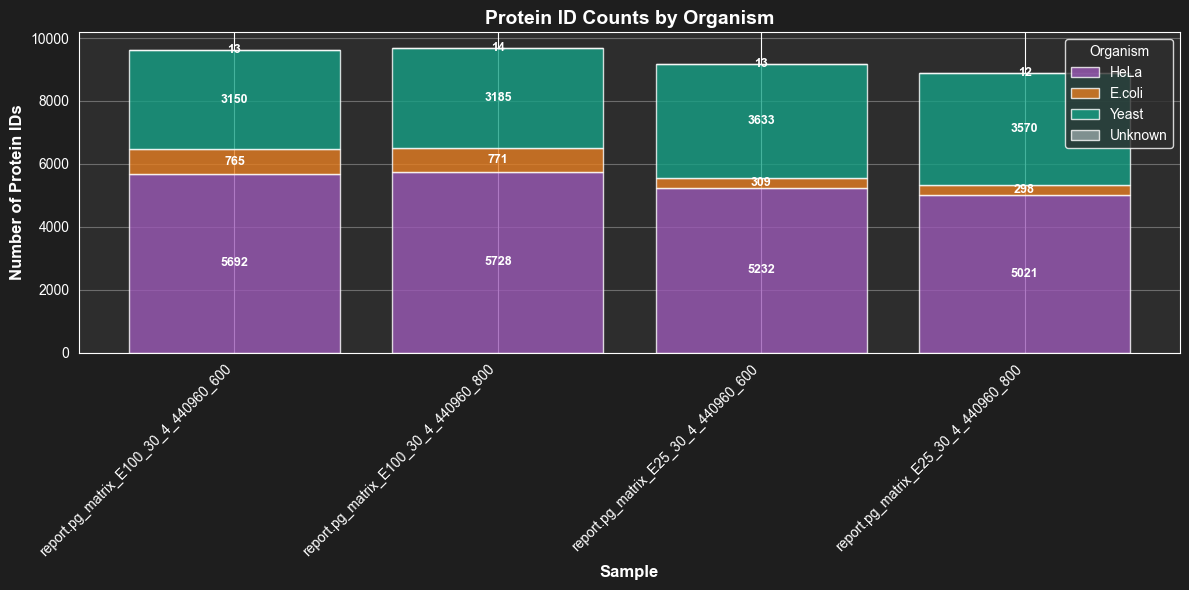

In [41]:
ORGANISMS = ["HeLa", "E.coli", "Yeast"]
COLORS = {"HeLa": "#9b59b6", "E.coli": "#e67e22", "Yeast": "#16a085", "Unknown": "#95a5a6"}

counts = data.groupby(["Source_File", "Organism"]).size().unstack(fill_value=0)
org_order = ORGANISMS + ["Unknown"]
counts = counts.reindex(
    columns=[col for col in org_order if col in counts.columns], fill_value=0
)

print("Protein ID Counts by Sample:")
print(counts)
print()

fig, ax = plt.subplots(figsize=(12, 6))

bottom = np.zeros(len(counts))
for organism in counts.columns:
    ax.bar(
        range(len(counts)), counts[organism], bottom=bottom,
        label=organism, color=COLORS.get(organism, "#95a5a6"), alpha=0.8
    )
    bottom += counts[organism].values

for i, sample in enumerate(counts.index):
    y_offset = 0
    for organism in counts.columns:
        count = counts.loc[sample, organism]
        if count > 0:
            bar_height = count
            y_pos = y_offset + bar_height / 2
            
            ax.text(
                i, y_pos, str(int(count)),
                ha='center', va='center',
                fontsize=9, fontweight='bold',
                color='white'
            )
            y_offset += bar_height

ax.set_xlabel("Sample", fontsize=12, fontweight="bold")
ax.set_ylabel("Number of Protein IDs", fontsize=12, fontweight="bold")
ax.set_title("Protein ID Counts by Organism", fontsize=14, fontweight="bold")
ax.legend(title="Organism", fontsize=10, loc="upper right")
ax.grid(axis="y", alpha=0.3)
ax.set_xticks(range(len(counts)))
ax.set_xticklabels(counts.index, rotation=45, ha="right")
plt.tight_layout()
plt.show()

## 9. Plotting Function for Ratio Comparison

Define function to create box plots showing log2 intensity ratio distributions for each organism and experimental run. Box plots display:
- Quartiles (box)
- Median (line inside box)
- Mean (white square marker)
- Whiskers extending to min/max values
- Individual outliers as data points

In [42]:
def plot_ratio_comparison(ax, results, sorted_mixes, title, color, reference_line):
    data_arrays = [r[0] for r in results]
    mix_labels = [r[1] for r in results]
    positions = np.arange(1, len(data_arrays) + 1)
    
    bp = ax.boxplot(
        data_arrays,
        positions=positions,
        widths=0.6,
        patch_artist=True,
        showfliers=True,
        showmeans=True,
        flierprops=dict(
            marker="o", markerfacecolor=color, markersize=3,
            alpha=0.4, markeredgecolor="none"
        ),
        meanprops=dict(
            marker="s", markerfacecolor="white", 
            markeredgecolor="white", markersize=5
        ),
    )
    
    for patch in bp["boxes"]:
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
        patch.set_edgecolor("white")
        patch.set_linewidth(1.5)
    
    plt.setp(bp["whiskers"], color="white", linewidth=1.5)
    plt.setp(bp["caps"], color="white", linewidth=1.5)
    plt.setp(bp["medians"], color="#2c3e50", linewidth=2.5)
    
    for i, data_arr in enumerate(data_arrays):
        median_val = np.median(data_arr)
        ax.text(
            i + 1, median_val, f"{median_val:.2f}",
            fontsize=9, va="bottom", ha="center", color="white", 
            fontweight="bold", 
            bbox=dict(boxstyle="round,pad=0.3", 
                     facecolor="black", alpha=0.5, edgecolor="none")
        )
    
    ax.axhline(y=reference_line, color="#f39c12", linestyle="--", 
               linewidth=2, alpha=0.9, 
               label=f"Expected: {reference_line}")
    
    ax.set_ylabel("Log2 Intensity Ratio", fontsize=11, fontweight="bold")
    ax.set_title(title, fontsize=12, fontweight="bold")
    ax.set_xticks(positions)
    ax.set_xticklabels(mix_labels, rotation=45, ha="right", fontsize=9)
    ax.grid(axis="y", alpha=0.3)
    ax.legend(fontsize=9, loc="upper right")

print("✓ Plotting function defined")

✓ Plotting function defined


## 10. Generate Intensity Ratio Plots

Create 3-panel stacked visualization showing log2 intensity ratios for each organism:
- **Top**: HeLa (expected ratio ≈ 0 - constant concentration)
- **Middle**: E.coli (expected ratio ≈ -2 - log2(25/100))
- **Bottom**: Yeast (expected ratio ≈ +1 - log2(150/75))

Each panel shows box plot distribution of protein ratios with individual data points shown as outliers and expected value marked with reference line.

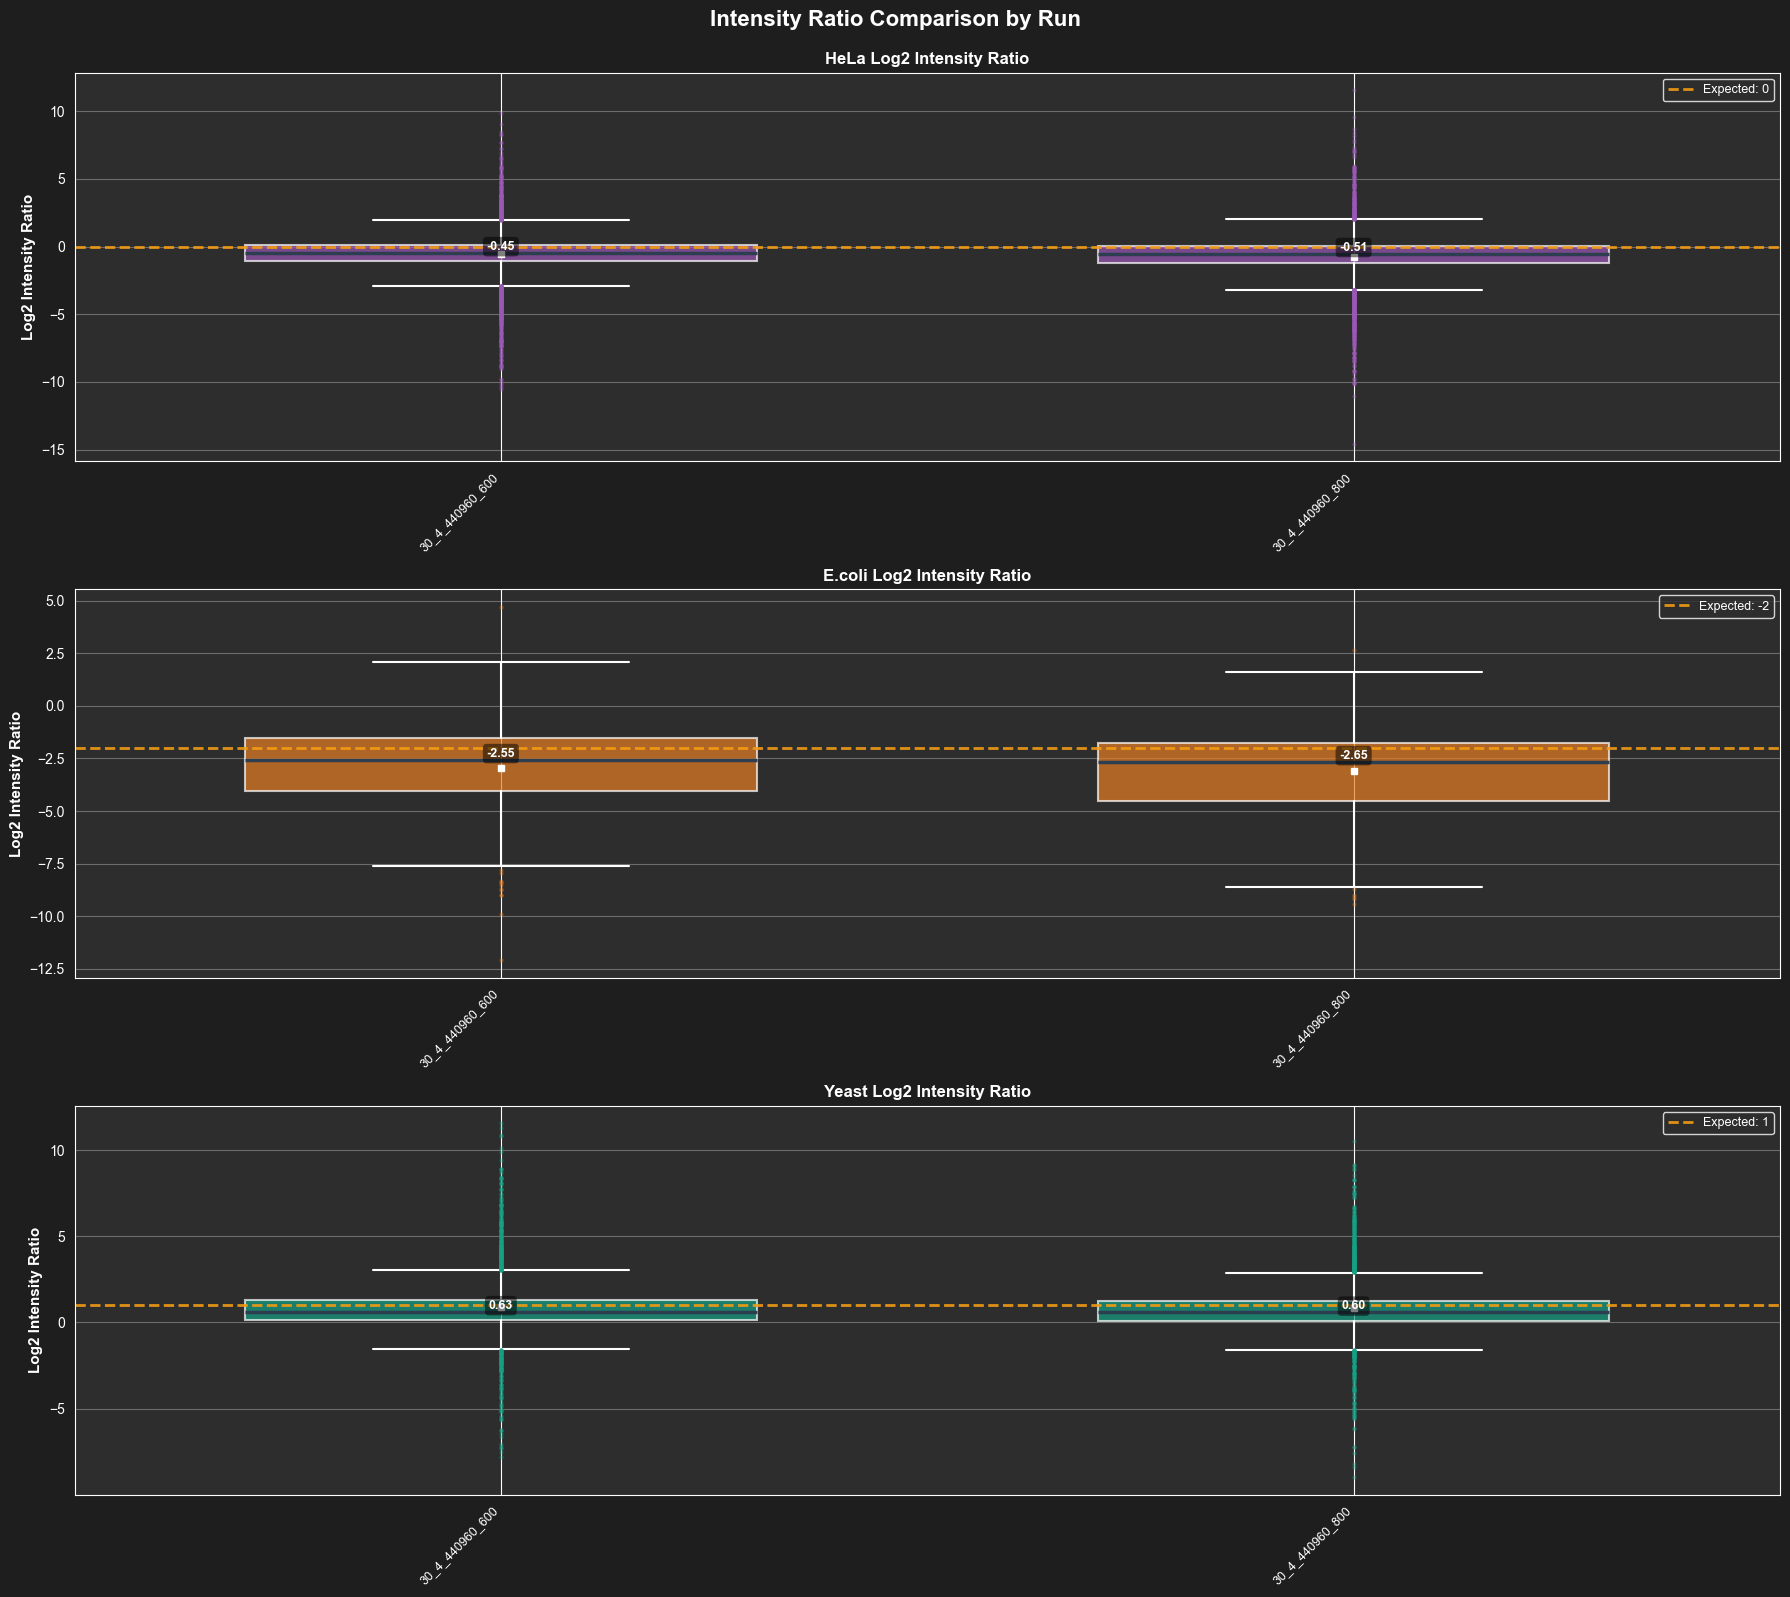


✓ Plots generated successfully


In [43]:
if hela_results or ecoli_results or yeast_results:
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(18, 16))
    
    if hela_results:
        plot_ratio_comparison(
            ax1, hela_results, sorted_mixes,
            title="HeLa Log2 Intensity Ratio",
            color="#9b59b6",
            reference_line=0
        )
    else:
        ax1.text(0.5, 0.5, "No HeLa data", ha="center", va="center",
                transform=ax1.transAxes, fontsize=14)
        ax1.set_ylabel("Log2 Intensity Ratio", fontsize=11, fontweight="bold")
        ax1.set_title("HeLa Log2 Intensity Ratio", fontsize=12, fontweight="bold")
    
    if ecoli_results:
        plot_ratio_comparison(
            ax2, ecoli_results, sorted_mixes,
            title="E.coli Log2 Intensity Ratio",
            color="#e67e22",
            reference_line=-2
        )
    else:
        ax2.text(0.5, 0.5, "No E.coli data", ha="center", va="center",
                transform=ax2.transAxes, fontsize=14)
        ax2.set_ylabel("Log2 Intensity Ratio", fontsize=11, fontweight="bold")
        ax2.set_title("E.coli Log2 Intensity Ratio", fontsize=12, fontweight="bold")
    
    if yeast_results:
        plot_ratio_comparison(
            ax3, yeast_results, sorted_mixes,
            title="Yeast Log2 Intensity Ratio",
            color="#16a085",
            reference_line=1
        )
    else:
        ax3.text(0.5, 0.5, "No Yeast data", ha="center", va="center",
                transform=ax3.transAxes, fontsize=14)
        ax3.set_ylabel("Log2 Intensity Ratio", fontsize=11, fontweight="bold")
        ax3.set_title("Yeast Log2 Intensity Ratio", fontsize=12, fontweight="bold")
    
    plt.suptitle(
        "Intensity Ratio Comparison by Run",
        fontsize=16,
        fontweight="bold",
        y=0.995
    )
    plt.tight_layout()
    plt.show()
    
    print("\n✓ Plots generated successfully")
else:
    print("⚠ No results to plot - check that your data contains valid E25/E100 pairs")

## 11. Statistical Summaries

Calculate and display statistical summaries (count, median, mean, std, quartiles) for each organism's intensity ratios across all experimental runs.

In [44]:
# Calculate and display statistics for all organisms
def print_stats(results, organism_name):
    if results:
        print(f"{organism_name} Statistics:")
        print("=" * 60)
        for ratios, mix_id in results:
            print(f"\n{mix_id}:")
            print(f"  Count: {len(ratios)}")
            print(f"  Median: {np.median(ratios):.3f}")
            print(f"  Mean: {np.mean(ratios):.3f}")
            print(f"  Std: {np.std(ratios):.3f}")
            print(f"  Q1-Q3: {np.percentile(ratios, 25):.3f} - {np.percentile(ratios, 75):.3f}")
    else:
        print(f"No {organism_name} results")

print_stats(hela_results, "HeLa")
print("\n")
print_stats(ecoli_results, "E.coli")
print("\n")
print_stats(yeast_results, "Yeast")

HeLa Statistics:

30_4_440960_600:
  Count: 5011
  Median: -0.449
  Mean: -0.577
  Std: 1.802
  Q1-Q3: -1.072 - 0.147

30_4_440960_800:
  Count: 4863
  Median: -0.514
  Mean: -0.749
  Std: 1.911
  Q1-Q3: -1.246 - 0.057


E.coli Statistics:

30_4_440960_600:
  Count: 306
  Median: -2.553
  Mean: -2.956
  Std: 2.241
  Q1-Q3: -4.024 - -1.547

30_4_440960_800:
  Count: 294
  Median: -2.650
  Mean: -3.101
  Std: 2.200
  Q1-Q3: -4.505 - -1.751


Yeast Statistics:

30_4_440960_600:
  Count: 3106
  Median: 0.628
  Mean: 0.891
  Std: 1.838
  Q1-Q3: 0.157 - 1.310

30_4_440960_800:
  Count: 3106
  Median: 0.598
  Mean: 0.814
  Std: 1.783
  Q1-Q3: 0.095 - 1.223


## 12. Validation Report

Validate that intensity ratios match expected patterns for each organism:
- **HeLa**: Expected ≈ 0 (constant concentration), PASS if |median| < 0.5
- **E.coli**: Expected ≈ -2 (4-fold reduction), PASS if -2.5 < median < -1.5  
- **Yeast**: Expected ≈ +1 (2-fold increase), PASS if 0.5 < median < 1.5

Results indicate whether sample preparation and instrument performance meet specifications.

In [45]:
print("Validation Summary:")
print("=" * 60)

if hela_results:
    hela_medians = [np.median(r[0]) for r in hela_results]
    
    print("\nHeLa Expected Pattern:")
    print(f"  Median range: {min(hela_medians):.2f} to {max(hela_medians):.2f}")
    print(f"  Average median: {np.mean(hela_medians):.2f}")
    print(f"  Expected: ~0 (constant concentration)")
    print(f"  Status: {'✓ PASS' if abs(np.mean(hela_medians)) < 0.5 else '⚠ CHECK'}")

if ecoli_results:
    ecoli_medians = [np.median(r[0]) for r in ecoli_results]
    
    print("\nE.coli Expected Pattern:")
    print(f"  Median range: {min(ecoli_medians):.2f} to {max(ecoli_medians):.2f}")
    print(f"  Average median: {np.mean(ecoli_medians):.2f}")
    print(f"  Expected: ~-2 (log2(25/100) = -2)")
    print(f"  Status: {'✓ PASS' if -2.5 < np.mean(ecoli_medians) < -1.5 else '⚠ CHECK'}")

if yeast_results:
    yeast_medians = [np.median(r[0]) for r in yeast_results]
    
    print("\nYeast Expected Pattern:")
    print(f"  Median range: {min(yeast_medians):.2f} to {max(yeast_medians):.2f}")
    print(f"  Average median: {np.mean(yeast_medians):.2f}")
    print(f"  Expected: ~+1 (log2(150/75) = 1)")
    print(f"  Status: {'✓ PASS' if 0.5 < np.mean(yeast_medians) < 1.5 else '⚠ CHECK'}")

print("\n✓ Analysis complete!")

Validation Summary:

HeLa Expected Pattern:
  Median range: -0.51 to -0.45
  Average median: -0.48
  Expected: ~0 (constant concentration)
  Status: ✓ PASS

E.coli Expected Pattern:
  Median range: -2.65 to -2.55
  Average median: -2.60
  Expected: ~-2 (log2(25/100) = -2)
  Status: ⚠ CHECK

Yeast Expected Pattern:
  Median range: 0.60 to 0.63
  Average median: 0.61
  Expected: ~+1 (log2(150/75) = 1)
  Status: ✓ PASS

✓ Analysis complete!


## Summary

This notebook provides a complete workflow for analyzing mass spectrometry proteomics data from the Orbitrap Astral using DIA-NN outputs:

1. **Import & Configure** (Cell 1): Set up libraries and plotting styles
2. **Define Patterns** (Cell 2): Establish organism identification rules
3. **Load Data** (Cells 3-4): Select and process TSV files
4. **Explore Data** (Cell 5): View organism distribution and data summary
5. **Calculate Ratios** (Cells 6-7): Compute E25/E100 intensity ratios
6. **Visualize** (Cells 8-10): Create protein counts and ratio distribution plots
7. **Analyze Statistics** (Cell 11): Display median, mean, and quartile summaries
8. **Validate Results** (Cell 12): Check if ratios match expected biological patterns

**Expected Outcomes**: Ratios should match theoretical predictions, confirming proper sample preparation and instrument performance.